# Adhering to constraints

This notebook explains our approach to `smallness regularization`, with the goal of adhering to prior knowledge of topography we're aiming to recover. In the scenario of a sediment-basement contact inversion, if we know the basement depth at a few points from drill holes or seismic data, we want the inverted results to adhere to these points, which we refer to as `constraints`. 

Again, we will use the same synthetic data from the past two user guides. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import pandas as pd
import verde as vd
import xarray as xr
from antarctic_plots import utils as ap_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 80000, 0, 60000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Starting topography

Sample the starting topography at 10 random locations and regrid with those sampled values. This sumulates only knowing the depth to this topography at 10 boreholes.

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

# re-sample the starting topography at the constraint points to see how the gridded did
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE at the constraints between the starting and true topography: {rmse:.2f} m")

RMSE at the constraints between the starting and true topography: 0.03 m


returning original grid
returning original grid


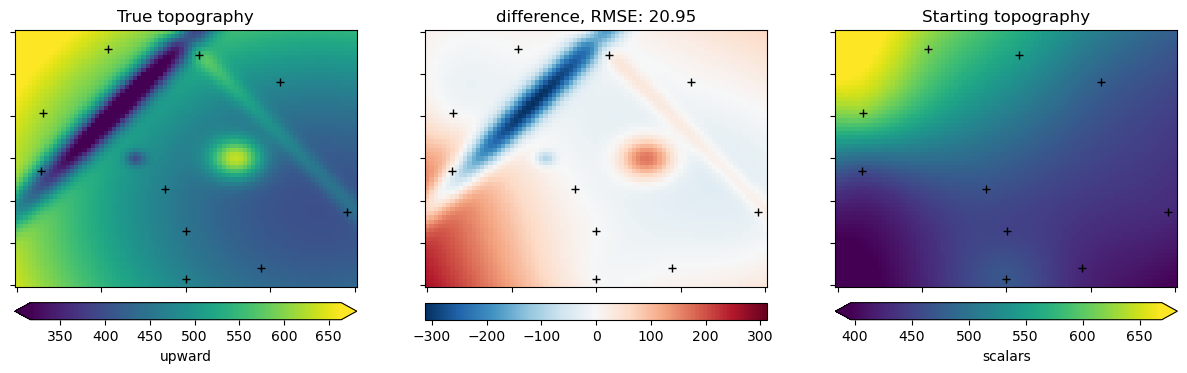

In [11]:
_ = ap_utils.grd_compare(
    true_topography,
    starting_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

### Prism layer

In [5]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

### Forward gravity of prism layer

In [6]:
# make pandas dataframe of locations to calculate gravity
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["observed_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav
0,0.0,0.0,1000.0,9.841928
1,0.0,1000.0,1000.0,11.119944
2,0.0,2000.0,1000.0,11.057737
3,0.0,3000.0,1000.0,10.781017
4,0.0,4000.0,1000.0,10.437176
...,...,...,...,...
4936,60000.0,76000.0,1000.0,3.722437
4937,60000.0,77000.0,1000.0,3.730724
4938,60000.0,78000.0,1000.0,3.722855
4939,60000.0,79000.0,1000.0,3.647590


## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

In [7]:
# prisms are created between the mean and the topography of the starting model
zref = starting_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.841928,-6.470039,16.311967,0,16.311967
1,0.0,1000.0,1000.0,11.119944,-7.734912,18.854856,0,18.854856
2,0.0,2000.0,1000.0,11.057737,-7.974260,19.031997,0,19.031997
3,0.0,3000.0,1000.0,10.781017,-8.012728,18.793745,0,18.793745
4,0.0,4000.0,1000.0,10.437176,-7.977723,18.414899,0,18.414899
...,...,...,...,...,...,...,...,...
4936,60000.0,76000.0,1000.0,3.722437,-0.318346,4.040782,0,4.040782
4937,60000.0,77000.0,1000.0,3.730724,-0.442539,4.173263,0,4.173263
4938,60000.0,78000.0,1000.0,3.722855,-0.557036,4.279891,0,4.279891
4939,60000.0,79000.0,1000.0,3.647590,-0.647426,4.295016,0,4.295016


## Weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

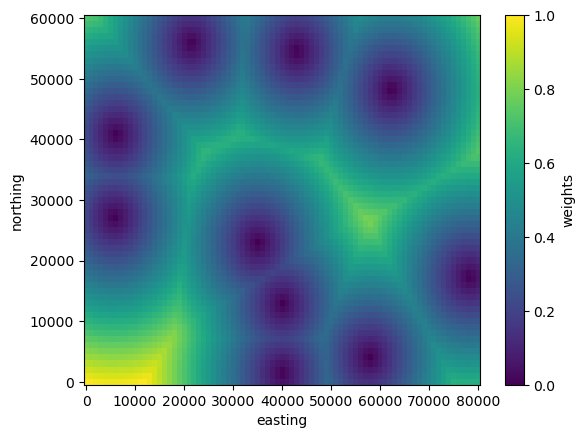

In [8]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
min_dist = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
starting_prisms["weights"] = min_dist
starting_prisms.weights.plot()

## Perform inversion
Now we can perform the inversion, supplied the argument `weights_after_solving=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. Note that we have increased the `max_iterations` from 10 to 20. This is because the weighting grid reduces the correction values at each iterations, resulting in the need for more iterations.

INFO:root:starting inversion
INFO:root:extracted zref is 486.32032837622575
INFO:root:extracted prism spacing is 1000.0
INFO:root:extracted density contrast is 2669
INFO:root:
 #################################### 
 iteration 1


INFO:root:Layer correction median: -7.8193 m, RMSE:69.7331 m
INFO:root:updated misfit RMSE: 4.2962
INFO:root:updated L2-norm: 2.0727, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.3409, tolerance: 1.001
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 3.5129 m, RMSE:38.8166 m
INFO:root:updated misfit RMSE: 2.8057
INFO:root:updated L2-norm: 1.675, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.2374, tolerance: 1.001
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 5.1873 m, RMSE:25.5194 m
INFO:root:updated misfit RMSE: 1.9972
INFO:root:updated L2-norm: 1.4132, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.1853, tolerance: 1.001
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 3.2261 m, RMSE:18.2913 m
INFO:root:updated misfit RMSE: 1.5057
INFO:root:updated L2-norm: 1.2271, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.1517, 

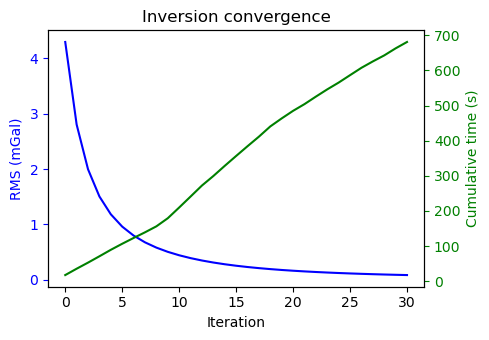

In [12]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.05,
    # set stopping criteria
    max_iterations=50,
    l2_norm_tolerance=0.3,
    delta_l2_norm_tolerance=1.001,
    # enable the use of weights
    weights_after_solving=True,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


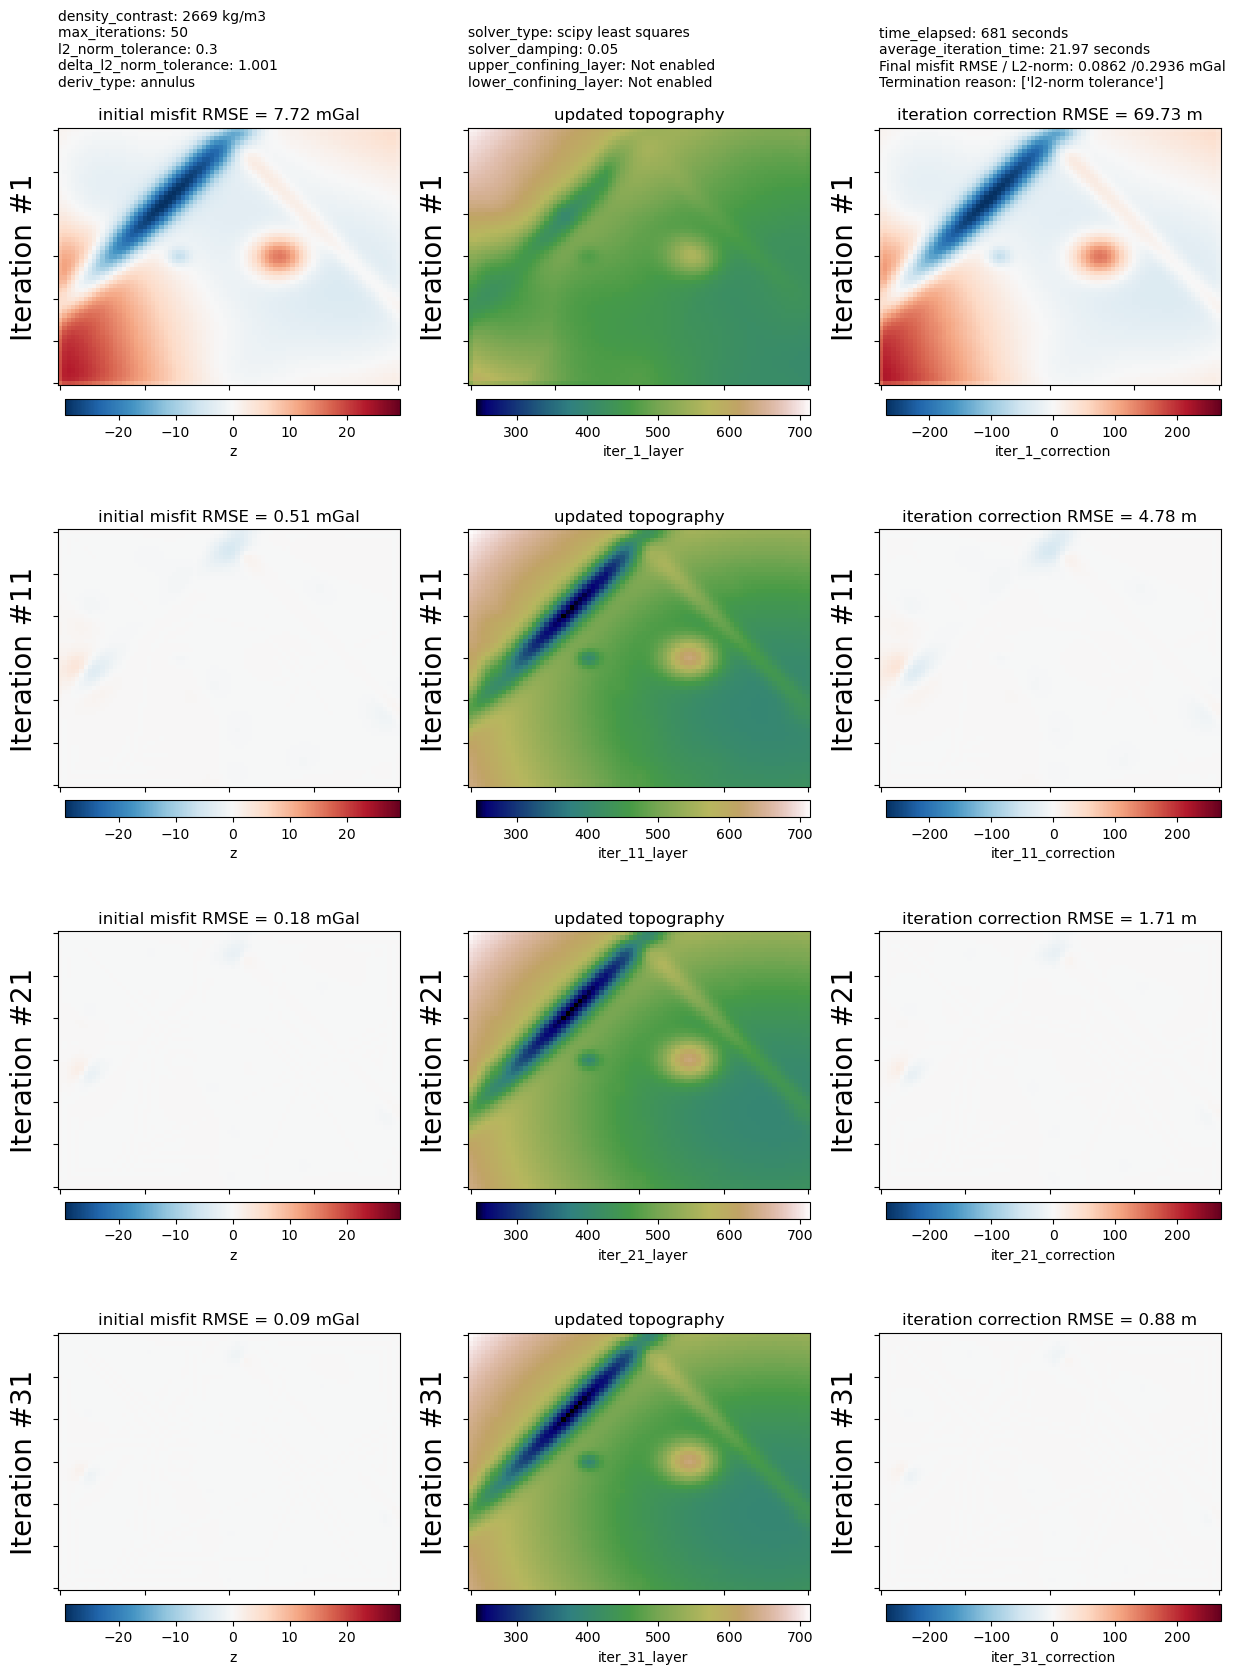

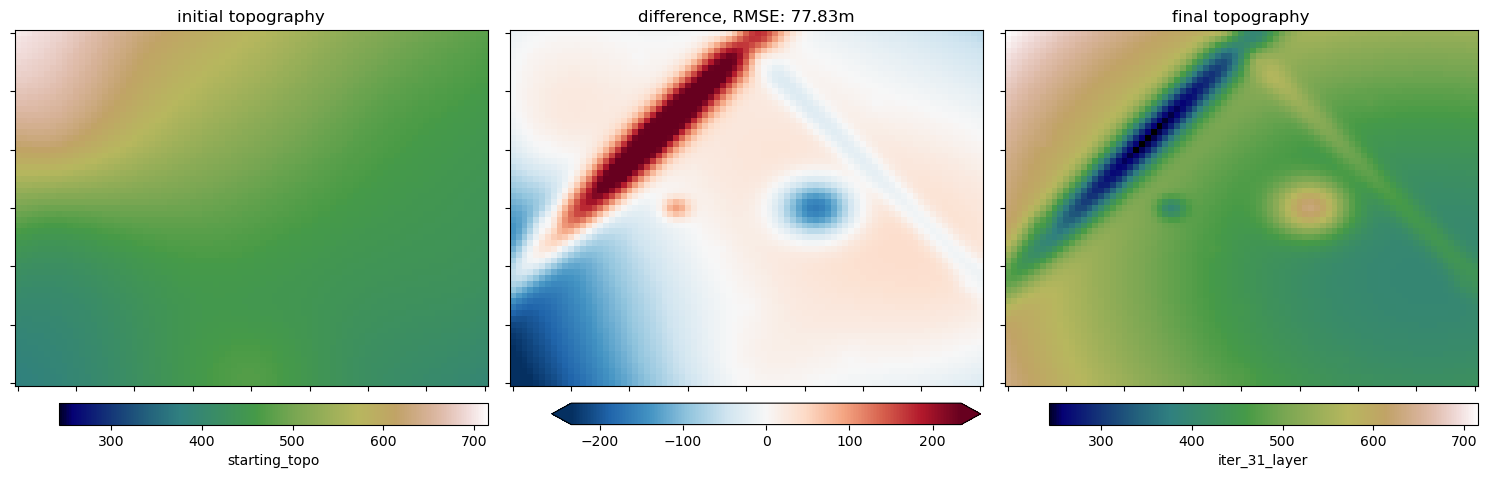

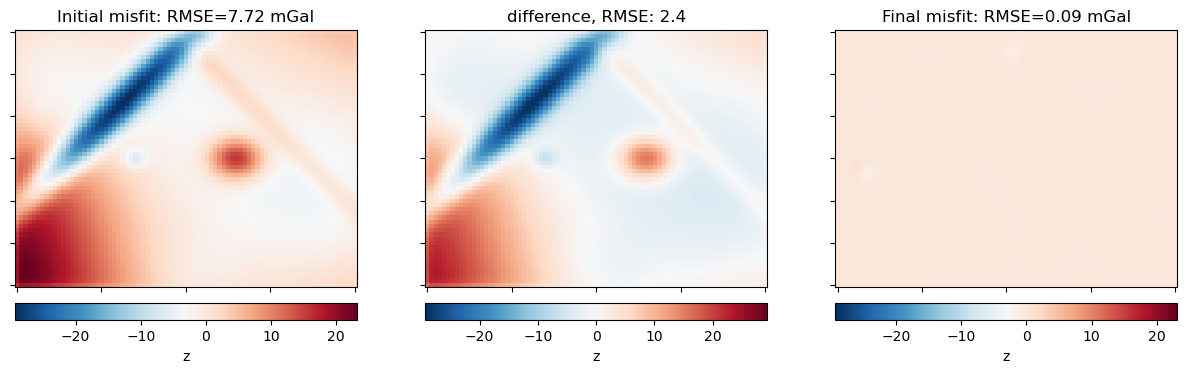

In [13]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid


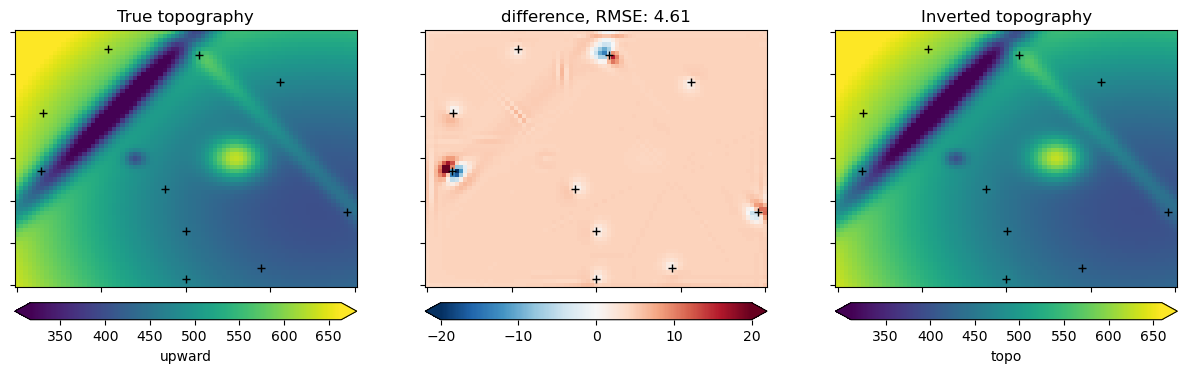

In [14]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

Similar to the past example, including the starting model help the inversion reduce the RMSE from ~9 m to ~5 m. Let's see if including the weighting grid helped this inversion adhere to the 10 constraint points.

In [15]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 1.02 m


The RMSE between the constraint's true values and the inverted topography values at the constraints has been reduced from ~ 5 m to ~ 1 m. The lower difference values can be seen by the low values (white colors) in the middle plot above.

#